## Support Vector Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('cleaned_city_Day.csv')
df.head(10)

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,AQI,AQI_Bucket,Month,Year
0,Ahmedabad,2015-01-01,58.37,107.96,0.92,18.22,17.15,14.89,0.920,27.64,133.36,149.0,Moderate,1,2015
1,Ahmedabad,2015-01-02,58.37,107.96,0.97,15.69,16.46,14.89,0.970,24.55,34.06,106.0,Moderate,1,2015
2,Ahmedabad,2015-01-03,58.37,107.96,17.40,19.30,29.70,14.89,17.400,29.07,30.70,303.0,Very Poor,1,2015
3,Ahmedabad,2015-01-04,58.37,107.96,1.70,18.48,17.97,14.89,1.700,18.59,36.08,106.0,Moderate,1,2015
4,Ahmedabad,2015-01-05,58.37,107.96,22.10,21.42,37.76,14.89,22.100,39.33,39.31,330.0,Very Poor,1,2015
5,Ahmedabad,2015-01-06,58.37,107.96,45.41,38.48,81.50,14.89,45.410,45.76,46.51,401.0,Severe,1,2015
6,Ahmedabad,2015-01-07,58.37,107.96,112.16,40.62,130.77,14.89,112.160,32.28,33.47,401.0,Severe,1,2015
7,Ahmedabad,2015-01-08,58.37,107.96,80.87,36.74,96.75,14.89,80.870,38.54,31.89,401.0,Severe,1,2015
8,Ahmedabad,2015-01-09,58.37,107.96,29.16,31.00,48.00,14.89,29.160,58.68,25.75,372.0,Very Poor,1,2015
9,Ahmedabad,2015-01-10,58.37,107.96,16.28,7.04,0.00,14.89,16.245,8.29,4.55,289.0,Poor,1,2015


In [3]:
pollutants = df.columns[2:11].values
pollutants

array(['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3'],
      dtype=object)

In [4]:
# Separate features and response variables
x = df.iloc[:, 2:11]
y = df.loc[:, 'AQI']

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state=42)

In [6]:
print(f"Actual Data size: {df.shape}")
print(f"Training Data size: {x_train.shape}")
print(f"Test Data size: {x_test.shape}")

Actual Data size: (27963, 15)
Training Data size: (19574, 9)
Test Data size: (8389, 9)


In [7]:
# Scaling of feature variables
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

In [8]:
# Scaling of response variables
from sklearn.preprocessing import StandardScaler
sc_y = StandardScaler()
y_train = sc_y.fit_transform(np.array(y_train).reshape(-1,1))
y_test = sc_y.transform(np.array(y_test).reshape(-1,1))

In [10]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform
param_grid = {
    'kernel': ['rbf'], 
    'C': loguniform(0.1, 1000), # C (Regularization parameter)
                                # Logarithmic scale is often good for C as its optimal value can vary widely.
    'epsilon': uniform(0.01, 0.5), # epsilon (SVR tube parameter): ranges from 0.01 to 0.01 + 0.5 = 0.51, sampled uniformly.
                                   # Controls the width of the insensitivity zone.
    'gamma': loguniform(0.0001, 10), # gamma (Kernel coefficient for 'rbf'): ranges from 0.0001 to 10, sampled logarithmically.
                                     # Also often varies widely and benefits from loguniform sampling.
}

random_search_svr = RandomizedSearchCV(
    estimator=SVR(),
    param_distributions=param_grid,
    n_iter=50, 
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search_svr.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024CCF8E8CB0>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024CCF81C9E0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024CCF8C40E0>,
                                        'kernel': ['rbf']},
                   random_state=42, scoring='r2', verbose=2)

In [11]:
# Display the best results
print("Best parameters found: ", random_search_svr.best_params_)

Best parameters found:  {'C': 5.762487216478598, 'epsilon': 0.07101911742238941, 'gamma': 0.029914693021302164, 'kernel': 'rbf'}


In [12]:
best_svr_model = random_search_svr.best_estimator_
y_pred = best_svr_model.predict(x_test)

In [13]:
# De-scaling of response variable
y_test = sc_y.inverse_transform(y_test.reshape(-1,1))
y_pred = sc_y.inverse_transform(y_pred.reshape(-1,1))
y_pred[:5]

array([[ 68.52030007],
       [391.54702999],
       [ 98.45889953],
       [ 68.48989872],
       [ 85.17211803]])

In [14]:
# Mathematical measure to check the accuracy of prediction
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 21.56691581416591
MSE: 2093.474326410123
RMSE: 45.754500613711464
R2: 0.8768603777485933


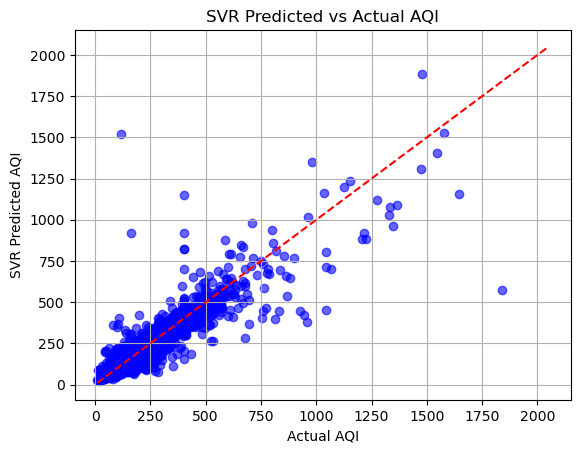

In [15]:
# Plotting scatterplot
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # 45-degree reference line
plt.xlabel("Actual AQI")
plt.ylabel("SVR Predicted AQI")
plt.title("SVR Predicted vs Actual AQI")
plt.grid(True)
plt.show()

In [16]:
# considering only 70 points, starting from a random position to check the fit visually.
import random
random.seed(42)
random_integer = random.randint(0, 8000)

df_SVR = pd.DataFrame({'Actual':y_test[random_integer:random_integer+70].flatten(), 'Predicted':y_pred[random_integer:random_integer+70].flatten()})
df_SVR.head(10)

,Actual,Predicted
0,69.0,54.609539
1,413.0,416.696169
2,189.0,147.061550
3,78.0,126.337646
4,179.0,175.649974
5,71.0,75.876645
6,110.0,81.167218
7,323.0,323.429672
8,65.0,67.047210
9,214.0,207.323025


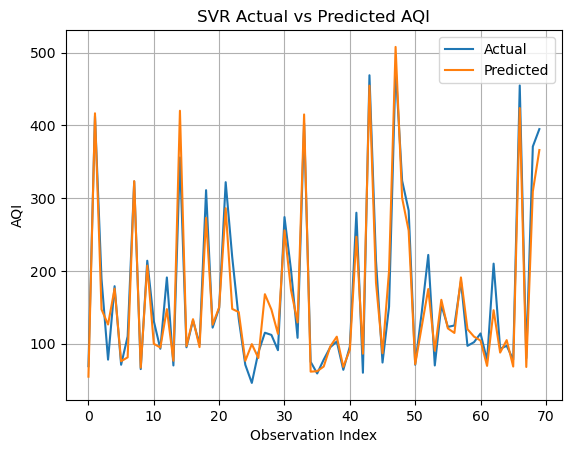

In [17]:
# Plotting line diagram (IT IS TO BE NOTED THAT THE X-AXIS DOES NOT REPRESENT TIME POINTS)
df_SVR.plot(kind='line')
plt.title('SVR Actual vs Predicted AQI')
plt.xlabel('Observation Index')
plt.ylabel('AQI')
plt.savefig('LineDiag_SVR.png')
plt.grid()
plt.show()